# Artifact EDA

In [164]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns

from functools import reduce
from PIL import Image

In [166]:
sns.set_style('darkgrid')

## Setup

In [205]:
root = '.'

label_file = f'{root}/proj_labels.csv'
image_dir = f'{root}/map-proj-v3_2'
temp_dir = f'{root}/tmp'

## Load Data

In [3]:
df = pd.read_csv(label_file)

## Sample Artifact

In [157]:
def load_img(img):
    return Image.open(img).convert('L')

In [4]:
art_file = os.path.join(image_dir, 'TRA_000828_1805_RED-0104-brt.jpg')

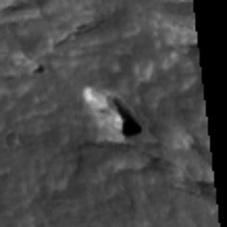

In [35]:
art_image = load_img(art_file)
art_image

## Artifact Detection

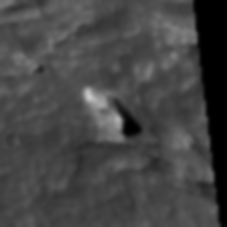

In [11]:
blurred = cv2.GaussianBlur(np.array(art_image), (9, 9), 0)
Image.fromarray(blurred)

In [84]:
_, mask = cv2.threshold(blurred, 1, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

Idenitified artifacts are indeed close to if not 0 exactly

In [85]:
mask

array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)

Find the components based on the mask

In [113]:
analysis = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S) 
(totalLabels, label_ids, values, centroid) = analysis 

This has picked up a small black like shape mid image

In [114]:
values

array([[    0,     0,   220,   227, 46436],
       [  193,     0,    34,   227,  4722],
       [  118,   104,    24,    33,   371]], dtype=int32)

Resolve this by making two assumptions:

- 1 The real image component will always have the largest area
- 2 The artifacts will always have an area > 2000

In [120]:
def filter_areas(values: np.array, threshold: int=2000) -> np.array:
    filter_idx = values[:, cv2.CC_STAT_AREA] > threshold
    return values[filter_idx]

def order_areas(values: np.array) -> np.array:
    areas = values[:, cv2.CC_STAT_AREA]
    sorted_idx = np.argsort(areas)[::-1] # reverse the sort
    return values[sorted_idx]

def get_bboxes(values) -> np.array:
    return values[:, :-1]

In [118]:
values = filter_areas(values)
values = order_areas(values)

In [119]:
values

array([[    0,     0,   220,   227, 46436],
       [  193,     0,    34,   227,  4722]], dtype=int32)

In [122]:
bboxs = get_bboxes(values)

Now we need to remove the intersection between the bounding boxes

In [250]:
def remove_intersection(bbox1, bbox2, margin: int=5) -> list[int]:
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    xA = max(x1, x2)
    yA = max(y1, y2)
    xB = min(x1 + w1, x2 + w2)
    yB = min(y1 + h1, y2 + h2)

    inter_width = max(0, xB - xA)
    inter_height = max(0, yB - yA)

    if inter_height == 0 or inter_width == 0:
        return bbox1

    if x1 < xA:
        return (x1, y1, xA - x1 - margin, h1)
    if x1 + w1 > xB:
        return (xB + margin, y1, x1 + w1 - xB - margin, h1)
    if y1 < yA:
        return (x1, y1, w1, yA - y1 - margin)

    return (x1, yB + margin, w1, y1 + h1 - yB - margin)


In [124]:
x, y, w, h = reduce(remove_intersection, bboxs)
print(x, y, w, h)

0 0 193 227


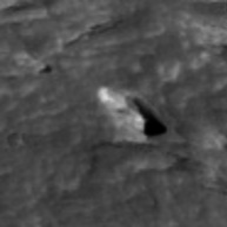

In [125]:
art_crop = art_image.crop((x, y, x+w, y+h))
art_crop = art_crop.resize((art_image.height, art_image.width))
art_crop

## Test Multiple Orientations

In [258]:
def get_mask(img: Image.Image, inv: bool=True):
    blurred = cv2.GaussianBlur(np.array(img), (9, 9), 0)
    mask_flags = cv2.THRESH_BINARY_INV if inv else cv2.THRESH_BINARY
    _, mask = cv2.threshold(blurred, 1, 255, mask_flags)
    return mask

def remove_artifact(img: Image.Image, threshold: int=2000):
    mask = get_mask(img)
    values = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)[2]

    values = filter_areas(values, threshold)
    values = order_areas(values)
    bboxs = get_bboxes(values)

    x, y, w, h = reduce(remove_intersection, bboxs)

    img_crop = img.crop((x, y, x+w, y+h))
    img_crop = img_crop.resize((img.height, img.width))
    return img_crop

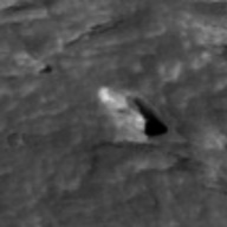

In [252]:
remove_artifact(art_image)

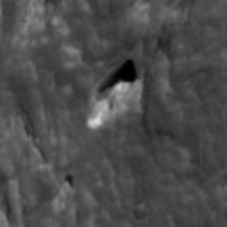

In [253]:
remove_artifact(art_image.rotate(90))

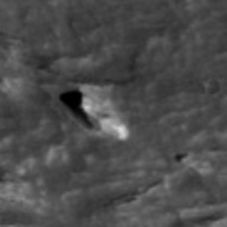

In [254]:
remove_artifact(art_image.rotate(180))

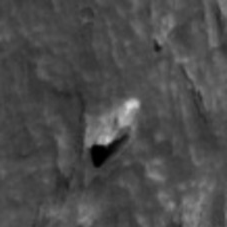

In [255]:
remove_artifact(art_image.rotate(270))

## Estimate Number of Artifact Images

In [190]:
def has_artifact(img: str) -> bool:
    img = os.path.join(image_dir, img)
    img = load_img(img)
    mask = get_mask(img)
    values = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)[2]
    values = filter_areas(values)
    return len(values) > 1

In [191]:
df['artifact'] = df['image'].apply(has_artifact)


Text(0.5, 1.0, 'Artifact Distribution')

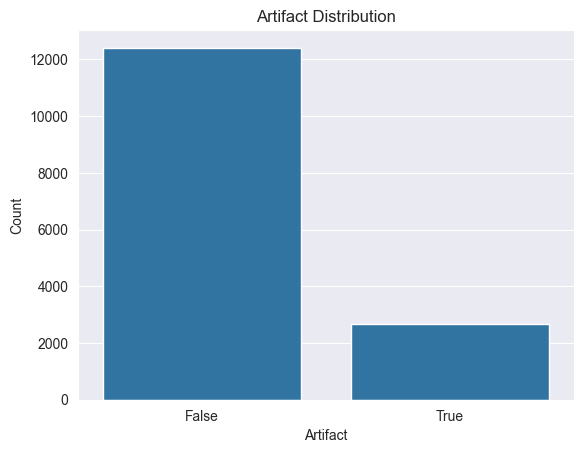

In [192]:
ax = sns.countplot(data=df, x='artifact')
ax.set_ylabel('Count')
ax.set_xlabel('Artifact')
ax.set_title('Artifact Distribution')

Since each photo is augmented ~6 times (not counting test images) then each photo is represented ~7 times so we adjust the estimate accordingly for uniqueness

In [195]:
def get_baseimg(img: str) -> str:
    img = os.path.splitext(img)[0]
    parts = img.split('-')
    return f'{parts[0]}-{parts[1]}.jpg'

In [196]:
df['base'] = df['image'].apply(get_baseimg)

In [202]:
base_df = (df[['base', 'artifact']]
           .groupby('base')
           .max('artifact')
           .reset_index())

Text(0.5, 1.0, 'Base Artifact Distribution')

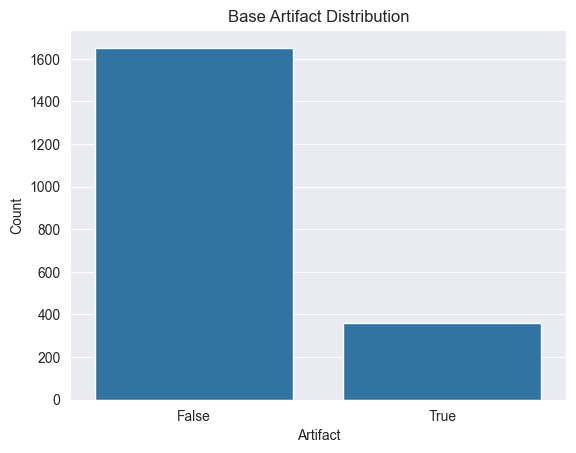

In [203]:

ax = sns.countplot(data=base_df, x='artifact')
ax.set_ylabel('Count')
ax.set_xlabel('Artifact')
ax.set_title('Base Artifact Distribution')

Seeing as theres much fewer baseline images ~390, we can perform the correction on these and do a side by side manual verification before safely applying to all artifacts

In [204]:
base_df.head()

,base,artifact
0,ESP_011289_1950_RED-0009.jpg,True
1,ESP_011289_1950_RED-0044.jpg,False
2,ESP_011289_1950_RED-0066.jpg,False
3,ESP_011289_1950_RED-0092.jpg,False
4,ESP_011289_1950_RED-0102.jpg,False


In [260]:
for img_file in base_df[base_df['artifact'] == True]['base']:
    img_path = os.path.join(image_dir, img_file)
    img = load_img(img_path)

    clean_img = remove_artifact(img, threshold=1500)

    conjoin = Image.new('L', (img.width * 2, img.height))
    conjoin.paste(im=img, box=(0, 0))
    conjoin.paste(im=clean_img, box=(img.width, 0))
    conjoin.save(os.path.join(temp_dir, img_file))